# Exploration of Twitter attitudes toward Presidental Candidates
- used tweepy library to scrape data & output json file
- filtered the listener stream based on keywords: 'trump','cruz','kasich','rubio', 'carson','clinton','sanders' 

In [49]:
from pymongo import MongoClient
import json
import tweepy
from tweepy import Stream
from tweepy.streaming import StreamListener
import time
import numpy as np
import tweetExplore_fns as fns
import importlib
import matplotlib
import matplotlib.pyplot as plt
from textblob import TextBlob
from matplotlib import gridspec
import seaborn as sns
import pandas as pd

sns.set_context("talk")
sns.set_style('darkgrid')
sns.set_context('talk')

importlib.reload(fns);
%matplotlib inline



## *Initial Organization of the Data*

In [2]:
#  import data 
# with open('raw_tweets10min.json') as data_file:
# with open('../data/raw_tweetsfilter10min_poli.json') as data_file:
# with open('raw_tweets10min_loc.json') as data_file:
# with open('raw_tweets40min_bosSC.json') as data_file:
with open('../data/raw_tweets1_5hr_candidates.json') as data_file:
    rawdata = json.load(data_file)

# selects only tweets that have text 
tweet_list = fns.extract_tweets(rawdata)
        
#  extract indices for tweets that also have a fields of interest
coord_index_list = fns.extract_indices(tweet_list,"coordinates")

# extract tweets that also have a gps coordinate 
coord_tweet_list = fns.extract_tweets_fieldOfInterest(tweet_list,"coordinates")

print('N Tweets', len(tweet_list),'N coordinates:',len(coord_index_list))

N Tweets 189042 N coordinates: 129



- Have a decent number of tweets scraping for 90 minutes! 
- But there are too few GPS coordinates to really do anything interesting :-( 


## *Sentiment Analysis*

- Are the tweets about each candidate positive or negative? 
- But first, are some candidates getting tweeted about more than others? 

#### Total Number of Tweets per Candidate
- count and plot the total number of tweets per candidate
- extract the sentiment score for each tweet

In [3]:
candidates = ['Trump','Cruz','Kasich','Rubio','Carson','Clinton','Sanders'] #track list

# for each candidate
tweet_index_store = []
subjectivity_store = []
polarity_store = []
for iperson,val in enumerate(candidates):
    # save each candidate's list of polarity etc. in a list 
    person_sentiment_polarity, person_sentiment_subjectivity, person_tweetInd = fns.extract_sentiment(tweet_list,candidates[iperson])
    # store tweet polarity (sentiment pos/neg) for each candidate
    polarity_store.append(person_sentiment_polarity)
    # store tweet subjectivity for each candidate
    subjectivity_store.append(person_sentiment_subjectivity)
    # store indices for tweets about each candidate
    tweet_index_store.append(person_tweetInd)

Trump   # tweets: 110392
Cruz   # tweets: 18673
Kasich   # tweets: 1601
Rubio   # tweets: 42703
Carson   # tweets: 2608
Clinton   # tweets: 9846
Sanders   # tweets: 7256


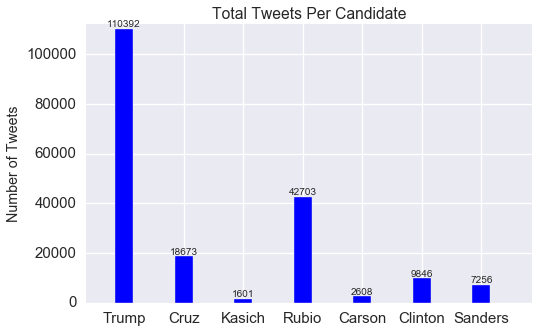

In [23]:
candidate_tweets = []

# for each candidate, get counts of: 
# tweets, positive tweets, negative tweets, average positive sentiment, average negative sentiment
for iperson,candidate in enumerate(candidates):
    candidate_tweets.append(len(tweet_index_store[iperson])) # number tweets total
    
# function to label the bars with their value
def autolabelInt(rects):
    """attach labels to bars, integers"""
    for rect in rects:
        height = rect.get_height();
        plt.text(rect.get_x() + rect.get_width()/2., height+.03,
                '%d' % int(height),
                ha='center', va='bottom');

# Plot the total number of tweets per candidate
fig = plt.figure(figsize=(8,5));
matplotlib.rc('xtick',labelsize = 15)
matplotlib.rc('ytick',labelsize = 15)
ymax = np.max(candidate_tweets) + 2000
width = .3

ind = np.arange(len(candidates))+1
rect1 = plt.bar(ind, candidate_tweets, width, color = 'blue')

plt.title("Total Tweets Per Candidate")
plt.xlim([.5,8])
plt.ylim([0,ymax])
plt.ylabel('Number of Tweets')
plt.xticks(ind + width/2, candidates)
autolabelInt(rect1);

### Positive vs. Negative Tweets
- count the number of positive and negative tweets per candidate
- store the avgerage sentiment score for each candidate

In [35]:
# sort tweets into positive/negative lists for each candidate 

store_pos_polarity = []
store_ind_pos_polarity = []
store_tweet_pos_polarity = []
store_neg_polarity = []
store_ind_neg_polarity = []
store_tweet_neg_polarity = []
pos_neg_ratio = []
pos_tweets = []
neg_tweets = []
avg_pos = []
avg_neg = []

# for each candidate
for iperson,val in enumerate(candidates):
    # sort each sentiment score into positive or negative sentiment categories, outputs are:
    # lists of each positive and negative sentiment score: pos_polarity, neg_polarity
    # lists of the indices for each tweet that has a positive/negative score: ind_pos_polarity, ind_neg_polarity
    # lists of the texts for each tweet that has a positive/negative tscore: tweet_pos_polarity, tweet_neg_polarity
    pos_polarity, neg_polarity, ind_pos_polarity, ind_neg_polarity,tweet_pos_polarity, tweet_neg_polarity = fns.sortTweetsPosNeg(iperson, polarity_store, tweet_index_store, tweet_list)
    
    # store each candidates lists in a master list
    store_pos_polarity.append(pos_polarity)             # list of positive sentiment scores
    store_ind_pos_polarity.append(ind_pos_polarity)     # list of indices of tweets w. positive sentiment scores
    store_tweet_pos_polarity.append(tweet_pos_polarity) # list of positive tweet texts
    store_neg_polarity.append(neg_polarity)             # list of negative sentiment scores
    store_ind_neg_polarity.append(ind_neg_polarity)     # list of indices of tweets w. negative sentiment scores 
    store_tweet_neg_polarity.append(tweet_neg_polarity) # list of negative tweet texts
    
    # get the ratio of positive to negative tweets
    pos_neg_ratio.append(len(ind_pos_polarity)/len(ind_neg_polarity))
    
    # get counts of # of positive/negative tweets, and the average positive/negative sentiment scores
    pos_tweets.append(len(ind_pos_polarity)) # number positive tweets
    neg_tweets.append(len(ind_neg_polarity)) # number negative tweets
    avg_pos.append(np.average(pos_polarity)) # avg positive tweet sentiment score
    avg_neg.append(np.average(neg_polarity)) # avg negative tweet sentiment score
    
    # print number of positive/negative tweets per person, and their average positive/negative sentiment score
    print(candidates[iperson],'# Tweets: Positive',len(ind_pos_polarity),'Negative',len(ind_neg_polarity),
          ' Avg. Sentiment: Positive %.2f' % np.average(pos_polarity),'Negative %.2f' % np.average(neg_polarity))


Trump # Tweets: Positive 37515 Negative 21795  Avg. Sentiment: Positive 0.35 Negative -0.30
Cruz # Tweets: Positive 7248 Negative 3368  Avg. Sentiment: Positive 0.34 Negative -0.29
Kasich # Tweets: Positive 638 Negative 296  Avg. Sentiment: Positive 0.37 Negative -0.23
Rubio # Tweets: Positive 14692 Negative 11474  Avg. Sentiment: Positive 0.32 Negative -0.25
Carson # Tweets: Positive 885 Negative 413  Avg. Sentiment: Positive 0.39 Negative -0.25
Clinton # Tweets: Positive 3577 Negative 1792  Avg. Sentiment: Positive 0.35 Negative -0.24
Sanders # Tweets: Positive 2184 Negative 1333  Avg. Sentiment: Positive 0.32 Negative -0.26


#### Positive and Negative Tweets per Candidate
- plot the number of positive and negative tweets per candidate
- plot the ratio of positive/negative tweets for each candidate

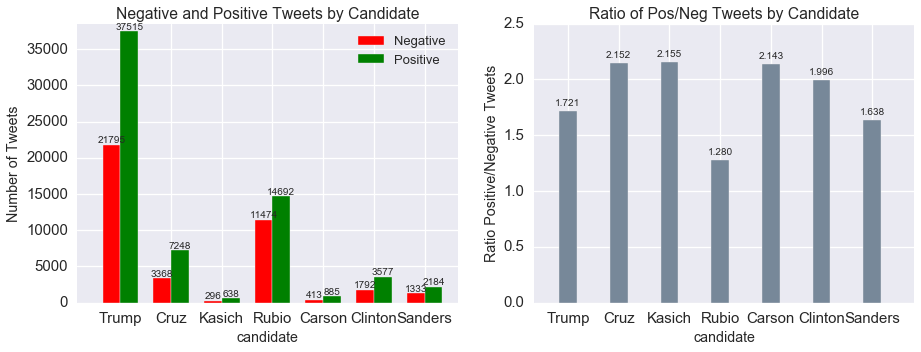

In [36]:
# initial variables for both graphs
width = 0.35       # the width of the bars
ind = np.arange(len(candidates))+1 # shift x location by 1 
ax = [0,1]

# set up figure + subplots
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax[0] = plt.subplot(gs[0])

# plot data for # positive or negative tweets
rectsNeg= ax[0].bar(ind, neg_tweets, width, color='r') 
rectsPos = ax[0].bar(ind + width, pos_tweets, width, color='g')

# set up axes
ymax = np.max([neg_tweets,pos_tweets]) + 1000 # get upper bound for graph
ax[0].set_xlim([.5,8])
ax[0].set_ylim([0,ymax])
ax[0].set_xticks(ind+width)

# add text for labels, title, legend
ax[0].set_title('Negative and Positive Tweets by Candidate')
ax[0].legend((rectsNeg[0], rectsPos[0]), ('Negative', 'Positive'))
ax[0].set_xlabel("candidate")
ax[0].set_ylabel("Number of Tweets")
ax[0].set_xticklabels(candidates)

# label bars with y value, integer
fns.autolabelInt(rectsNeg,ax,0,neg_tweets)
fns.autolabelInt(rectsPos,ax,0,pos_tweets)

# plot second graph - ratio of positive/negative tweets 
ax[1] = plt.subplot(gs[1])
rectRatio = ax[1].bar(ind, pos_neg_ratio, width, color = 'lightslategray') #'lightslategray' 'cadetblue'

# set up axes
ax[1].set_xticks(ind+width/2)
ax[1].set_xlim([.5,8])

# add text for labels, title, legend
ax[1].set_title('Ratio of Pos/Neg Tweets by Candidate')
ax[1].set_xlabel("candidate")
ax[1].set_ylabel("Ratio Positive/Negative Tweets")
ax[1].set_xticklabels(candidates) #rotation = 30

# label y value of bars, decimal 
fns.autolabelDec(rectRatio,ax,1,pos_neg_ratio)
plt.show();

- Here we can see that all candidates have more tweets with positive sentiment scores than negative scores. 
- However, the ratio of positive to negative tweets varies across candidates.
- It is interesting that the three GOP candidates with the fewest overall tweets have the better pos/negative ratios 
- This just looks at binary categorization with sentiment values of 0< or >0. The distribution of sentiment scores for each candidate could differ depending on how enthusiastic their supporters or adversaries are. 
- How positive are the positive tweets for each candidate? How negative are the negative?  

#### Degree of Sentiment

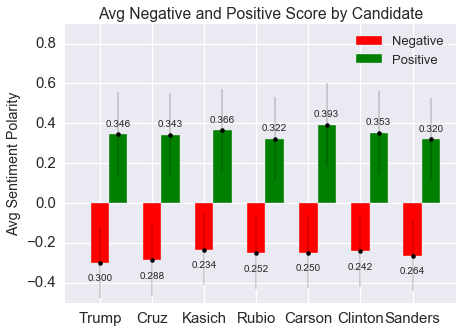

In [37]:

std_pos = []
std_neg = []
sterr_pos = []
sterr_neg = []
for icand, candidate in enumerate(candidates):
    # get standard deviation and standard error for the positive/negative scores for each candidate
    std_pos.append(np.std(store_pos_polarity[iperson]))
    std_neg.append(np.std(store_neg_polarity[iperson]))
    sterr_pos.append(np.std(store_pos_polarity[iperson])/np.sqrt(len(store_pos_polarity[iperson])))
    sterr_neg.append(np.std(store_neg_polarity[iperson])/np.sqrt(len(store_neg_polarity[iperson])))

# set up figure
ind = np.arange(len(candidates))+1 # shift x one
width = 0.35       # the width of the bars
fig = plt.figure(figsize=(7, 5)) 

# set up axes
plt.xticks(ind+width/2,candidates)
plt.xlim([.5,8])
plt.ylim([-.5,.9])

# plot avg positive/negative scores
rectsNeg = plt.bar(ind, avg_neg, width, color='r') #, yerr=menStd
rectsPos = plt.bar(ind + width, avg_pos, width, color='g') #, yerr=womenStd

# plot standard deviation errorbars
plt.errorbar(ind+width/2,avg_neg, yerr=std_neg,fmt='.', color = 'k', elinewidth = .3)
plt.errorbar(ind+width*1.5,avg_pos, yerr=std_pos,fmt='.',color = 'k', elinewidth = .3)

# add some text for labels, title and axes
plt.title('Avg Negative and Positive Score by Candidate')
plt.legend((rectsNeg[0], rectsPos[0]), ('Negative', 'Positive'))
# plt.xlabel("candidate")
plt.ylabel("Avg Sentiment Polarity")

# label bars with y value, decimal 
def autolabelDec(rects,vals):
    """attach labels to bars, 3 decimals"""
    i = 0
    for rect in rects:        
        height = rect.get_height()
        if vals[i] > 0:
            plt.text(rect.get_x() + rect.get_width()/2., height+.03,
                '%0.3f' % height,
                ha='center', va='bottom')
        else:
            plt.text(rect.get_x() + rect.get_width()/2., -1*(height+.1),
                '%0.3f' % height,
                ha='center', va='bottom')
        i = i+1

autolabelDec(rectsNeg,avg_neg)
autolabelDec(rectsPos,avg_pos)

plt.show();


- This visualization doesn't seem to show much of a difference between the candiates. 
- Perhaps looking at the distribution rather than the average would better represent the data 

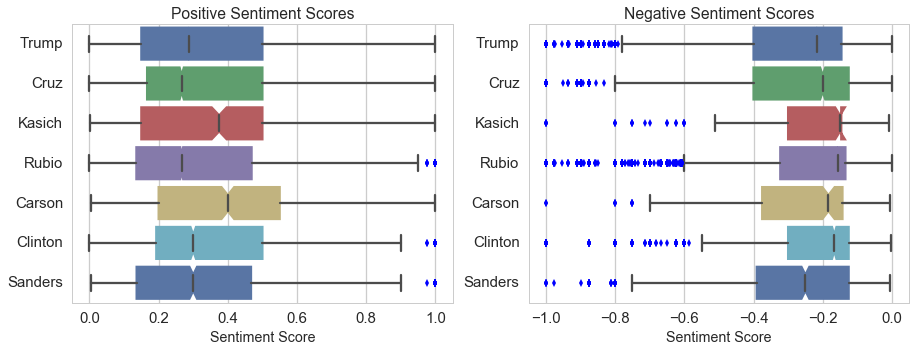

In [42]:
ax = [0,1]
sns.set_style("whitegrid")

# Box and Whisker plots for the positive sentiment ratings 

# set up figure + subplots
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax[0] = plt.subplot(gs[0])

# plot positive scores
ax[0] = sns.boxplot(data = store_pos_polarity, orient = "h", palette = "deep", notch = 1)
# ax[0] = sns.violinplot(data = store_pos_polarity, orient = "h", palette = "deep", notch = 1)

# set up axes/labels
ax[0].set_xlim([-.05,1.05])
ax[0].set_title('Positive Sentiment Scores');
ax[0].set_xlabel('Sentiment Score')
ax[0].set_yticklabels(candidates);


# Box and Whisker plots for the negative sentiment ratings 
ax[1] = plt.subplot(gs[1])

# plot negative scores
ax[1] = sns.boxplot(data = store_neg_polarity, orient = "h", palette = "deep", notch = 1)
# ax[1] = sns.violinplot(data = store_neg_polarity, orient = "h", palette = "deep")

# set up axes/labels
ax[1].set_xlim([-1.05,.05])
ax[1].set_xlabel('Sentiment Score')
ax[1].set_title('Negative Sentiment Scores');
ax[1].set_yticklabels(candidates);


- Now we can extract a little more information about the distribution of sentiment scores
- There doesn't seem to be a great amount of variability among the positive tweets for each candidate, other than Kasich and Carson's median tweet scores are higher than the other candidates. 
- The negative tweets show a bit more variability in their sentiment scores. 
- Kasich interestingly has the least negative distribution, with only a handful of tweets falling as outliers (greater than 1.5 interquartile range from the lower quartile)
- While having very few tweets, Kasich has the best Positive/Negative Tweet ratio, one of the higher positive sentiment medians, and the least negative distribution from the negative tweets in this dataset
- Rubio also seems to have a distribution that is skewed toward 0, resulting in many tweets judged as outliers

### Are these measures representative of other rankings?

#### Correlation of Sentiment with Other Ratings
- correlation of positive/negative sentiment ratio with Favorable/Unfavorable scores from Real Clear Politics

#### Correlation of Number of Tweets with Support 
- correlation of percent tweets in dataset mentioning a specific candidate, and the average polls reported on 538

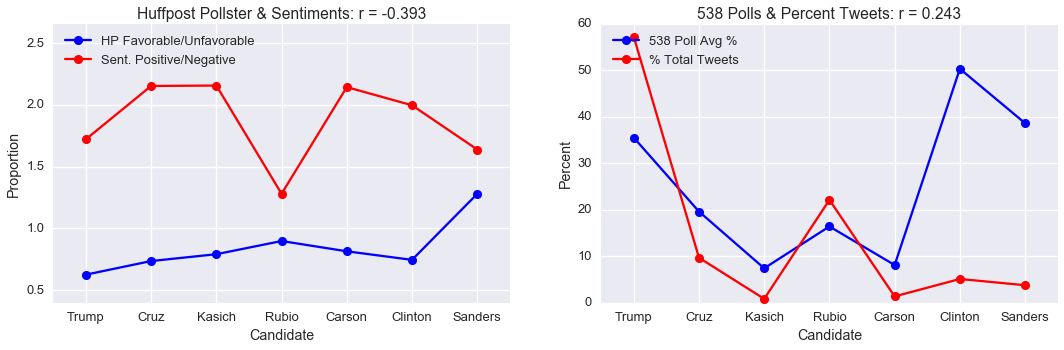

In [54]:
# favorable & unfavorable scores
# candidates = ['Trump','Cruz','Kasich','Rubio','Carson','Clinton','Sanders']
rcp_favorable = np.array([36.1, 34.7, 25.9, 36.3, 36.7, 40.0, 49.0]) # accessed from Huffpost Pollster 2/26/16
rcp_unfavorable = np.array([57.6, 47.1, 32.7, 40.4, 45.0, 53.6, 38.3]) # accessed from Huffpost Pollster 2/26/16

# ratio favorable / unfavorable poll
fav_unfav_ratio = rcp_favorable/rcp_unfavorable

# pearson corrleation between favorable/unfavorable and positive/negative ratios
rcp_pearson_corr = np.corrcoef(fav_unfav_ratio, pos_neg_ratio)

# 538 Polling averages from 2/26/16 
# ['Trump','Cruz','Kasich','Rubio','Carson','Clinton','Sanders']
avg_538 = [35.5, 19.6, 7.4, 16.4, 8.1, 50.3, 38.6]

# pearson correlation between 538 average poll and % of tweets in dataset mentioning each candidate 
num_tweet_array = np.array(candidate_tweets)
proportion_tweets = (num_tweet_array/num_tweet_array.sum())*100
numTweets_538_pearson_corr = np.corrcoef(avg_538,proportion_tweets)


# plot the correlations
ind = np.arange(len(candidates))+1 # shift x one
ax = [0,1]
fig = plt.figure(figsize=(18, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax[0] = plt.subplot(gs[0])

# set up axes
# xind = np.arange(len(rcp_candidates))
ymax = np.max([rcp_pos_neg_ratio,fav_unfav_ratio]) + .5
# ax[0].set_xticks(xind)
ax[0].set_xticks(ind)
ax[0].set_ylim([.4,ymax])
ax[0].set_xlim([.5,len(candidates)+.5])

# plot ratios for Real Clear Politics
# lineFav = ax[0].plot(xind,fav_unfav_ratio,c='b',marker = 'o')
# linePos = ax[0].plot(xind,rcp_pos_neg_ratio,c='r',marker='o')
lineFav = ax[0].plot(ind,fav_unfav_ratio,c='b',marker = 'o')
linePos = ax[0].plot(ind,rcp_pos_neg_ratio,c='r',marker='o')


# labels
ax[0].set_xticklabels(rcp_candidates)
ax[0].set_title('Huffpost Pollster & Sentiments: r = %0.3f' % rcp_pearson_corr[0][1])
ax[0].set_ylabel("Proportion")
ax[0].set_xlabel("Candidate")
ax[0].legend((lineFav[0], linePos[0]), ('HP Favorable/Unfavorable', 'Sent. Positive/Negative'),loc = 2)

# plot ratios for 538
ax[1] = plt.subplot(gs[1])
line538 = ax[1].plot(ind,avg_538,c='b',marker = 'o')
lineProp = ax[1].plot(ind,proportion_tweets,c='r',marker='o')

# set up axes
ax[1].set_xticks(ind)
ax[1].set_xlim(.5,len(candidates)+.5)

# labels
ax[1].legend((line538[0], lineProp[0]), ('538 Poll Avg %', '% Total Tweets'),loc = 2)
ax[1].set_xticklabels(candidates)
ax[1].set_ylim([0,60])
ax[1].set_title('538 Polls & Percent Tweets: r = %0.3f' % numTweets_538_pearson_corr[0][1])
ax[1].set_ylabel("Percent")
ax[1].set_xlabel("Candidate")
plt.show;


- doesn't seem to be a correlation between the ratio of Favorable/Unfavorable ratings and number of Positive/Negative tweets
- there is a medium sized corrleation of r = ~.3 between the 538 polls and the total number of tweets
- looking at the data however, it seems like the Democrats may be throwing off the correlation


only 5 data points, but get sig. value for this - wha'ts probability you'd get 5 data points this correlated randomly... (p says just know this number in your back pocket) sns.jointdistplot 

#### Correlation of 538 Avg Polls and % Number of Tweets per Candidate - GOP only

In [46]:
rep_numTweets_538_pearson_corr = np.corrcoef(avg_538[:5],candidate_tweets[:5])
print('GOP only correlation coefficient between 538 Avg Polls and Number of Tweets:',
     rep_numTweets_538_pearson_corr[0][1])

GOP only correlation coefficient between 538 Avg Polls and Number of Tweets: 0.948878126421


- with a high correlation of r = ~.9, it seems as though the Poll data from 538 tracks along with the number of tweets about each candidate

## Who has a rival?
- looking into whether two candidates are mentioned in the same tweet

In [ ]:

rival_index_store = []
rival_count_store = []
# for each candidate
for iperson,val in enumerate(candidates):
    """extract counts and indices of tweets that mention more than one candidate"""
    current_inds = tweet_index_store[iperson]
    from textblob import TextBlob
    count = [0]*len(candidates)
    
    # remove current candidate from list
    rival_list_temp = np.arange(len(candidates)) 
    mask_self = np.ones(rival_list_temp.shape,dtype=bool)
    mask_self[iperson] = 0
    rival_list = rival_list_temp[mask_self]
    rival_index_temp = []
    # for each potential rival 
    for irival, rival in enumerate(rival_list):
        cur_rival_index = []
        cur_rival = candidates[rival]
        # for each tweet about the candidate
        for iind,textval in enumerate(current_inds):
            curidx = current_inds[iind]
            curtweet = tweet_list[curidx]["text"]
            curblob = TextBlob(curtweet)
            if curblob.words.count(cur_rival):
                count[rival] = count[rival] + 1
                cur_rival_index.append(current_inds[iind])
        rival_index_temp.append(cur_rival_index)
        
    rival_count_store.append(count)
    rival_index_store.append(rival_index_temp)
    print(val,count)

In [ ]:
# plot the proportion of tweets with a second candidate mentioned - for each candidate
sns.set_context('poster')
x = np.arange(len(candidates))
# plt.stackplot(x,np.array(rival_count_store))
df2 = pd.DataFrame(rival_count_store, columns=candidates)
df2.plot(kind='barh', stacked=True);
plt.yticks(x, candidates);


#### Find the top rival for each candidate

In [ ]:
maxRival = []
maxRival_ind = []
storeRivalTweets = []
candidates = ['Trump','Bush','Cruz','Kasich','Rubio','Clinton','Sanders'] #track list

for icand, cand in enumerate(candidates):
    # get list of all candidates except current one
    rival_list_temp = np.arange(len(candidates)) 
    mask_self = np.ones(rival_list_temp.shape,dtype=bool)
    mask_self[icand] = 0
    rival_array = rival_list_temp[mask_self]
    rival_list = rival_array.tolist()
    
    # get max count index of simultaneous mentions to select top rival 
    cur_maxRival_ind = np.argmax(rival_count_store[icand])
    # store index of max rival 
    maxRival_ind.append(cur_maxRival_ind)
    # store rival name 
    maxRival.append(candidates[cur_maxRival_ind])

    # index of rival from rival only list
    rival_only_ind = rival_list.index(cur_maxRival_ind)
    # store tweets with rival 
    storeRivalTweets.append(rival_index_store[icand][rival_only_ind])
    print(cand,"'s top rival is:",candidates[cur_maxRival_ind])

- Based on this measure, Trump is the only rival for the GOP candidates
- Clinton and Sanders are pit against each other more often than any Republican.

# Not clean / figured out


- Does the main issue change across candidates though? (Does Trump fight over different things with each candidate?)

In [ ]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import re
candidates = ['Trump','Bush','Cruz','Kasich','Rubio','Clinton','Sanders'] #track list

for icand, val in enumerate(candidates):
    print(icand, val,maxRival[icand])
    current_inds = storeRivalTweets[icand]
    textstring = []
    newSTOP = STOPWORDS
    newSTOP.union({'co','https','\'s','RT','\"RT','https','https:','\'https','Trump','#Trump','Trump\'s', maxRival[icand],'#'+ maxRival[icand],maxRival[icand]+'\'s'})
    stoplistk = ['co','https','\'s','RT','\"RT','https','https:','\'https','Trump','#Trump','Trump\'s', maxRival[icand],'#'+ maxRival[icand],maxRival[icand]+'\'s']
    for iInd, val in enumerate(current_inds):
        curtweet = tweet_list[current_inds[iInd]]
        curtext = curtweet["text"]
        textstring.append(curtext)
    
    textjoined = ''
    for tweet in textstring:
#         print(tweet)
        textjoined = textjoined + ' ' + tweet
    textsplit = textjoined.split()
    newlist = [w for w in textsplit if not w in newSTOP]
    newlist = [w for w in newlist if not w in stoplistk]
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    newlist = [pattern.sub('', w) for w in newlist] 
    pattern2 = re.compile('.Trump.')
    newlist = [pattern2.sub('',w) for w in newlist]
    # print(klist)
    
    newstring = " ".join(newlist)
    textstringblob = TextBlob(newstring)
#     print(textstringblob.words)

    
    for iword in newSTOP:
#         print(iword)
        textstringblob.replace(iword,'')
#     print(textstringblob,'new')
    words = textstringblob.words
    word_counts = Counter(words)
    top_three = word_counts.most_common(10)
    print(top_three)
   

In [ ]:
pattern2

In [ ]:
# from nltk.corpus import stopwords
# templist = stopwords.words('english')
# templist
# newset = ('co','Trump')
# print(type(newset))
# newSTOP = tempstop.update(newset)
# print(newSTOP)
# # type(newSTOP)
#     newSTOP.update('co','https','\'s','RT','\"RT','\'https','Trump')
stoplist = ['co','https*','\'s','RT','\"RT','\'https','Trump','Rubio']
klist = [w for w in newlist if not w in stoplist]
import re
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
klist = [pattern.sub('', w) for w in klist] 
print(klist)

In [ ]:
newset

In [ ]:
ind = np.arange(len(candidates))  # the x locations for the groups
width = 0.35       # the width of the bars
from matplotlib import gridspec
fig = plt.figure(figsize = (40,10)) #figsize=(90, 90)
ax = []
gs = gridspec.GridSpec(3, 3, width_ratios=[1]*len(candidates))
for i, val in enumerate(candidates):
    ax.append(plt.subplot(gs[i]))
    tempwordcloud = fns.makeWordcloud(store_tweet_pos_polarity[i])
    ax[i].imshow(tempwordcloud)
    # add some text for labels, title and axes ticks
    ax[i].set_title('Positive Tweets about Candidate')
    ax[i].set_xlabel(candidates[i])

plt.show()

## Plot geographical coordinates of tweets

In [ ]:
# This just lets the output of the following code samples
#  display inline on this page, at an appropriate size.
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (10,20)

In [ ]:
import matplotlib
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# setup Lambert Conformal basemap.
m = Basemap(projection='lcc',width=12000000,height=9000000,
            resolution='l',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
#draw boundary, fill ocean color
m.drawmapboundary(fill_color='#CCFFFF')
# fill continents, set lake color
m.fillcontinents(color='#66CC99',lake_color='#CCFFFF') # '#6699CC'
# draw parallels and meridians. label only on edges of map
parallels = np.arange(0.,81,10.)
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[True,False,False,True])
# drawstates, if no linewidth will be empty
m.drawstates(linewidth = .5)
m.drawcoastlines()
m.drawcountries()
# m.drawcounties(linewidth = 0.05, linestyle = 'solid', color = 'k', antialiased = 1)

i = 0
while i < len(coords):
    # get current coordinates 
    lon, lat = coords[i]
    # convert to map projection coords.
    # Note that lon,lat can be scalars, lists or numpy arrays.
    xpt,ypt = m(lon,lat)
    # convert back to lat/lon
    lonpt, latpt = m(xpt,ypt,inverse=True)
    m.plot(xpt,ypt,'ro')  # plot a blue dot there
    label = 'Hello'
    plt.Text(xpt+1000, ypt+5000, label)
    # put some text next to the dot, offset a little bit
    # (the offset is in map projection coordinates)
#     plt.text(xpt+100000,ypt+100000,'Boulder (%5.1fW,%3.1fN)' % (lonpt,latpt))
#     plt.text(xpt+100000,ypt+100000,'(%5.1fW,%3.1fN)' % (i,lonpt,latpt))
    i = i + 1
plt.show()

In [ ]:
rcParams['figure.figsize'] = (20,20)

 
# make sure the value of resolution is a lowercase L,
#  for 'low', not a numeral 1
# my_map = Basemap(projection='ortho', lat_0=50, lon_0=-100,
#               resolution='l', area_thresh=1000.0)
# my_map = Basemap(projection='robin', lat_0=50, lon_0=-100,
#               resolution='l', area_thresh=1000.0)
my_map = Basemap(projection='merc', lat_0=42.36, lon_0=-71.06,
              resolution='h', area_thresh=.01, 
              llcrnrlon=-71.3, llcrnrlat=42.1,
              urcrnrlon=-70.9, urcrnrlat=42.6) 
#               llcrnrlon=-71.098709, llcrnrlat=42.328093,
#               urcrnrlon=-71.012192, urcrnrlat=42.389994) 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color='#66CC99')
my_map.drawstates(linewidth = .5)
my_map.drawmapboundary()
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))
# my_map.drawcounties(linewidth = 0.5)

# lon = -135.3318
# lat = 57.0799
# x,y = my_map(lon, lat)
# my_map.plot(x, y, 'bo', markersize=12)
i = 0
while i < len(coords):
    # get current coordinates 
    lon, lat = coords[i]
    # convert to map projection coords.
    # Note that lon,lat can be scalars, lists or numpy arrays.
    xpt,ypt = my_map(lon,lat)
    # convert back to lat/lon
    lonpt, latpt = my_map(xpt,ypt,inverse=True)
    my_map.plot(xpt,ypt,'ro')  # plot a blue dot there
    label = 'Hello'
    plt.Text(xpt+1000, ypt+5000, label)
    # put some text next to the dot, offset a little bit
    # (the offset is in map projection coordinates)
#     plt.text(xpt+100000,ypt+100000,'Boulder (%5.1fW,%3.1fN)' % (lonpt,latpt))
#     plt.text(xpt+100000,ypt+100000,'(%5.1fW,%3.1fN)' % (i,lonpt,latpt))
    i = i + 1
plt.show()